In [1]:
#make sure libraries like TensorFlow, Keras, NumPy, and Matplotlib are installed

import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tqdm import tqdm
import cv2
import os

x_train = []
y_train = []
folder_dir = r"/content/drive/MyDrive/American Sign Language Letters.v1-v1.tensorflow/train"
count = 0

for k in tqdm(os.listdir(folder_dir), desc='Processing images', unit='items'):
    count += 1
    if k.endswith('.jpg'):
        i = cv2.imread(os.path.join(folder_dir, k))
        #i = cv2.flip(i, 1)
        x_train.append(i)
        y_train.append(k[0])


x_valid = []
y_valid = []
folder_dir = r"/content/drive/MyDrive/American Sign Language Letters.v1-v1.tensorflow/valid"
count = 0

for k in tqdm(os.listdir(folder_dir), desc='Processing images', unit='items'):
    count += 1
    if k.endswith('.jpg'):
        i = cv2.imread(os.path.join(folder_dir, k))
        #i = cv2.flip(i, 1)
        x_valid.append(i)
        y_valid.append(k[0])


x_test = []
y_test = []
folder_dir = r"/content/drive/MyDrive/American Sign Language Letters.v1-v1.tensorflow/test"
count = 0

for k in tqdm(os.listdir(folder_dir), desc='Processing images', unit='items'):
    count += 1
    if k.endswith('.jpg'):
        i = cv2.imread(os.path.join(folder_dir, k))
        #i = cv2.flip(i, 1)
        x_test.append(i)
        y_test.append(k[0])

Processing images: 100%|██████████| 73/73 [00:14<00:00,  5.10items/s]


In [4]:
print(type(x_train[0]))

<class 'numpy.ndarray'>


In [5]:
y_train_nums = np.zeros((len(y_train)))
y_valid_nums = np.zeros((len(y_valid)))
y_test_nums = np.zeros(len(y_test))
for i in range(len(y_train)):
    val = ord(y_train[i])
    y_train_nums[i] = val-ord("A")

for i in range(len(y_valid)):
    val = ord(y_valid[i])
    y_valid_nums[i] = val-ord("A")

for i in range(len(y_test)):
    val = ord(y_test[i])
    y_test_nums[i] = val-ord("A")


In [6]:
def augment(x_lis, y_lis):
  x_aug_lis = []
  y_aug_lis = []

  for i in range(len(x_lis)):

    img = x_lis[i]
    # Get image dimensions
    height, width, _ = img.shape

    # Rotate and flip the image
    for angle in range(-15, 16, 3):  # Rotate between -45 to 45 degrees with a step of 15 degrees
        # Perform rotation
        rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
        rotated_image = cv2.warpAffine(img, rotation_matrix, (width, height))
        #plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
        #plt.show()
        x_aug_lis.append(rotated_image)
        y_aug_lis.append(y_lis[i])
    # Perform horizontal flip
    flipped_image = cv2.flip(img, 1)  # 1 for horizontal flip
    x_aug_lis.append(flipped_image)
    y_aug_lis.append(y_lis[i])
  return x_aug_lis, y_aug_lis

x_aug_train, y_aug_train = augment(x_train, y_train_nums)
x_aug_valid, y_aug_valid = augment(x_valid, y_valid_nums)
x_aug_test, y_aug_test = augment(x_test, y_test_nums)

In [7]:
w = 128
h = 128
x_train_rs = []
x_test_rs = []
x_valid_rs = []
for i in range(len(x_aug_train)):
    img = x_aug_train[i]
    x_train_rs.append(cv2.resize(img, (w, h)))

x_train_rs = np.array(x_train_rs)
x_train_rsh = x_train_rs.reshape((-1, w, h, 3))

for i in range(len(x_aug_valid)):
    img = x_aug_valid[i]
    x_valid_rs.append(cv2.resize(img, (w, h)))

x_valid_rs = np.array(x_valid_rs)
x_valid_rsh = x_valid_rs.reshape((-1, w, h, 3))

for i in range(len(x_aug_test)):
    img = x_aug_test[i]
    x_test_rs.append(cv2.resize(img, (w, h)))

x_test_rs = np.array(x_test_rs)
x_test_rsh = x_test_rs.reshape((-1, w, h, 3))

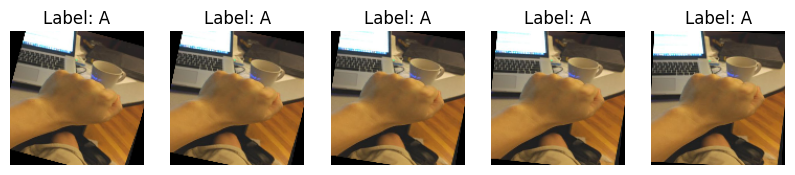

In [8]:
#Display a few sample images
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = cv2.cvtColor(x_train_rsh[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

1/1 [==============================] - 7s 7s/step


<ipython-input-9-8167df58f2bd>:55: RuntimeWarning: invalid value encountered in divide
  x /= x.std()  # Divide by standard deviation for scaling


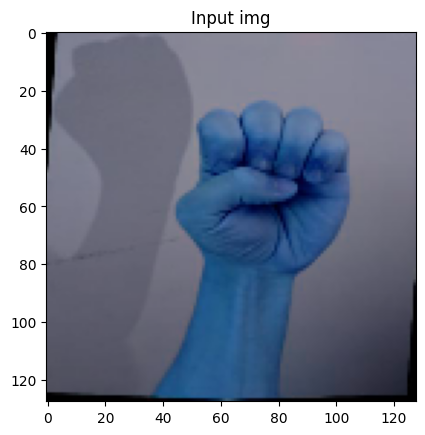

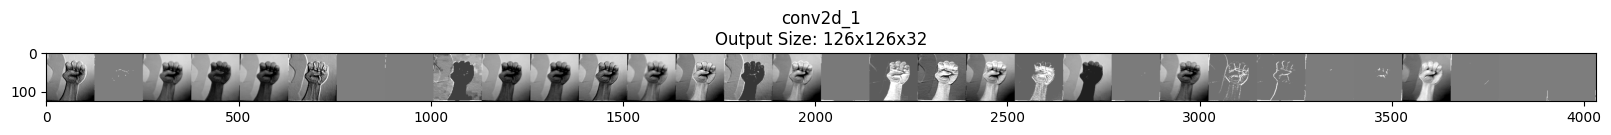

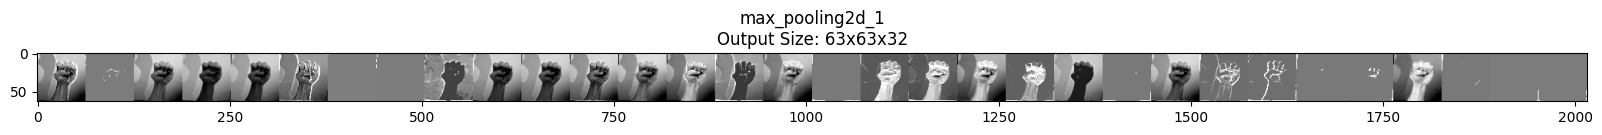

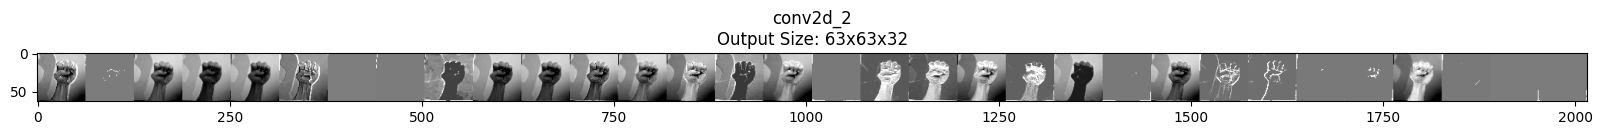

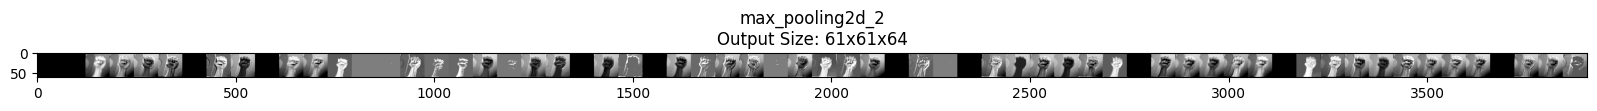

In [9]:
import tensorflow as tf
#Select a random MNIST image from the training set
random_index = np.random.randint(0, len(x_train_rsh))
img = x_train_rsh[random_index]
plt.title('Input img')
plt.imshow(img,cmap='gray')

#Create a simple CNN model with two convolutional layers and pooling
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3))) #16 kernels, 5x5 each
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))                          #32 kernels, 5x5 each
model.add(MaxPooling2D((2, 2),  strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))                          #64 kernels, 5x5 each
model.add(MaxPooling2D((2, 2),  strides=(2, 2)))
model.add(Dropout(0.25))


#img = img.reshape((28, 28, 1))  # Add the channel dimension
img = img / 255.0  # Normalize the pixel values to [0, 1]
img = np.expand_dims(img, axis=0)  # Add the batch dimension

#Create a model to visualize feature maps
layer_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

# Get the feature maps for the example image
feature_maps = visualization_model.predict(img)

# Visualize the feature maps
layer_names = ['conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2']

# Iterate through each layer and its corresponding feature maps
for layer_name, feature_map in zip(layer_names, feature_maps):
    # Get the number of feature maps in the current layer
    n_features = feature_map.shape[-1]

    # Get the size of each feature map (assuming they are square)
    size = feature_map.shape[1]

    # Create an empty grid to display all feature maps in this layer
    display_grid = np.zeros((size, size * n_features))



    # Iterate through each feature map in the current layer
    for i in range(n_features):
        # Extract the current feature map
        x = feature_map[0, :, :, i]

        # Normalize the values for better visualization
        x -= x.mean()  # Subtract the mean value to center around 0
        x /= x.std()  # Divide by standard deviation for scaling
        x *= 64  # Scale values for better visibility
        x += 128  # Shift values to be within the [0, 255] range
        x = np.clip(x, 0, 255).astype('uint8')  # Clip values to the [0, 255] range

        # Add the current feature map to the display grid
        display_grid[:, i * size: (i + 1) * size] = x

    # Set the scale for displaying the grid
    scale = 20. / n_features

    # Create a new figure to display the feature maps for this layer
    plt.figure(figsize=(scale * n_features, scale))

    # Set the title for this layer, along with input and output size
    plt.title(f'{layer_name}\nOutput Size: {size}x{size}x{n_features}')

    # Remove grid lines for a cleaner visualization
    plt.grid(False)

    # Display the feature maps in the current layer using the viridis colormap
    plt.imshow(display_grid, aspect='auto', cmap='gray')

# Show all the visualizations
plt.show()

Training CNN

Epoch 1/10
1236/1236 [==============================] - 15s 7ms/step - loss: 3.5949 - accuracy: 0.2965 - val_loss: 6.9243 - val_accuracy: 0.0683
Epoch 2/10
1236/1236 [==============================] - 8s 7ms/step - loss: 1.2447 - accuracy: 0.5477 - val_loss: 9.7591 - val_accuracy: 0.0666
Epoch 3/10
1236/1236 [==============================] - 7s 6ms/step - loss: 1.0015 - accuracy: 0.6519 - val_loss: 13.8921 - val_accuracy: 0.0735
Epoch 4/10
1236/1236 [==============================] - 8s 7ms/step - loss: 0.8077 - accuracy: 0.7336 - val_loss: 15.5926 - val_accuracy: 0.0718
Epoch 5/10
1236/1236 [==============================] - 7s 6ms/step - loss: 1.0028 - accuracy: 0.6754 - val_loss: 20.2515 - val_accuracy: 0.0845
Epoch 6/10
1236/1236 [==============================] - 9s 7ms/step - loss: 0.8404 - accuracy: 0.7174 - val_loss: 30.2414 - val_accuracy: 0.0787
Epoch 7/10
1236/1236 [==============================] - 7s 6ms/step - loss: 0.5243 - accuracy: 0.8271 - val_loss: 25.9190 - val_acc

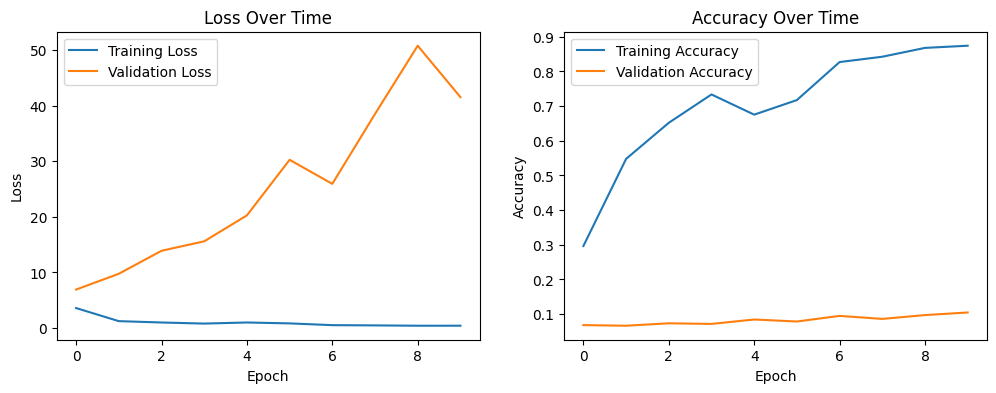

27/27 [==============================] - 0s 7ms/step - loss: 48.0411 - accuracy: 0.0880
Test Loss: 48.0411
Test Accuracy: 8.80%
27/27 [==============================] - 0s 4ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.01      0.17      0.02        12
           1       0.05      0.06      0.05        36
           2       0.28      0.33      0.30        48
           3       0.08      0.58      0.14        12
           4       0.00      0.00      0.00         0
           5       0.07      0.29      0.11        24
           6       0.26      0.70      0.38        60
           7       0.00      0.00      0.00        36
           8       0.00      0.00      0.00        24
           9       0.00      0.00      0.00        48
          10       0.00      0.00      0.00        48
          12       0.00      0.00      0.00        36
          13       0.00      0.00      0.00        36
          14       0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [10]:
#Flatten the feature maps and add fully connected dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(26, activation='softmax'))

#encode the labels(one-hot)
y_train_ohe = to_categorical(y_aug_train, 26)
y_valid_ohe = to_categorical(y_aug_valid, 26)
y_test_ohe = to_categorical(y_aug_test, 26)

#Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model
history = model.fit(x_train_rsh, y_train_ohe, validation_data=(x_valid_rsh, y_valid_ohe), epochs=10, batch_size=4)

#Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Time')

plt.show()

#Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test_rsh, y_test_ohe)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

#Generate predictions
y_pred = model.predict(x_test_rsh)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_ohe, axis=1)
# y_test_labels = y_test

#Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))
print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))